In [296]:
import pandas as pd
import numpy as np
from numpy import nan
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool,NumeralTickFormatter, WheelZoomTool
from statsmodels.tsa.stattools import adfuller
from bokeh.models.widgets import Panel, Tabs
from itertools import cycle

import matplotlib.pyplot as plt 
import seaborn as sns
import time
%matplotlib inline

# import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [297]:
park = pd.read_csv(r'F:\CSE 6242\Project\Data.csv')
location = pd.read_csv(r'F:\CSE 6242\Project\Location.csv')
park.head()

,ParkName,UnitCode,ParkType,Region,State,Year,Month,RecreationVisits
0,Abraham Lincoln Birthplace NHP,ABLI,National Historical Park,Southeast,KY,1979,1,"1,586"
1,Abraham Lincoln Birthplace NHP,ABLI,National Historical Park,Southeast,KY,1979,2,"3,036"
2,Abraham Lincoln Birthplace NHP,ABLI,National Historical Park,Southeast,KY,1979,3,"9,853"
3,Abraham Lincoln Birthplace NHP,ABLI,National Historical Park,Southeast,KY,1979,4,"33,087"
4,Abraham Lincoln Birthplace NHP,ABLI,National Historical Park,Southeast,KY,1979,5,"27,838"


In [298]:
location.head()

,Park Code,Latitude,Longitude
0,ACAD,44.35,-68.21
1,ARCH,38.68,-109.57
2,BADL,43.75,-102.50
3,BIBE,29.25,-103.25
4,BISC,25.65,-80.08


In [299]:
data = pd.merge(park, location, how= 'inner', left_on= 'UnitCode', right_on= 'Park Code')
data.drop(["Park Code", "ParkType"], axis = 1, inplace = True)

In [300]:
data = data.rename(columns= {'ParkName': 'Name', 'UnitCode': 'Code', "RecreationVisits": "Visit"})
data.head()

,Name,Code,Region,State,Year,Month,Visit,Latitude,Longitude
0,Acadia NP,ACAD,Northeast,ME,1979,1,"6,011",44.35,-68.21
1,Acadia NP,ACAD,Northeast,ME,1979,2,"5,243",44.35,-68.21
2,Acadia NP,ACAD,Northeast,ME,1979,3,"11,165",44.35,-68.21
3,Acadia NP,ACAD,Northeast,ME,1979,4,"219,351",44.35,-68.21
4,Acadia NP,ACAD,Northeast,ME,1979,5,"339,416",44.35,-68.21


In [301]:
data.to_csv(r"F:\CSE 6242\Project\Data_Final.csv", index = False)

In [302]:
df = data.apply(lambda x: x.astype(str).str.replace(',',''))
#Convert strings to numbers
df = df.apply(pd.to_numeric, errors= 'ignore', downcast = 'float') 

# Convert all float to int
m = df.select_dtypes(np.number)
df[m.columns]= m.round().astype(int)
df.head()
df1= df.copy()

In [303]:
df["Datetime"] = pd.to_datetime(['{}-{}-01'.format(y, m) for y, m in zip(df.Year, df.Month)])
df.index= pd.to_datetime(df['Datetime'])
df.drop(['Month', "Year", "Datetime"], axis = 1, inplace = True)
# df = df.reset_index()
df.head()

,Name,Code,Region,State,Visit,Latitude,Longitude
Datetime,,,,,,,
1979-01-01,Acadia NP,ACAD,Northeast,ME,6011,44,-68
1979-02-01,Acadia NP,ACAD,Northeast,ME,5243,44,-68
1979-03-01,Acadia NP,ACAD,Northeast,ME,11165,44,-68
1979-04-01,Acadia NP,ACAD,Northeast,ME,219351,44,-68
1979-05-01,Acadia NP,ACAD,Northeast,ME,339416,44,-68


In [304]:
Month_mean = df.groupby(df.index.month).mean().reset_index().rename(columns={"Datetime": "Month", "Visit": "Visit_mean"})
Month_mean.set_index("Month", drop= True, inplace= True)

Year_mean = df.groupby(df.index.year).sum().reset_index().rename(columns={"Datetime": "Year", "Visit": "Visit_mean"})
Year_mean.set_index("Year", drop= True, inplace= True)

In [278]:
# Month_mean

Text(0.5, 1.0, 'Monthly Visit')

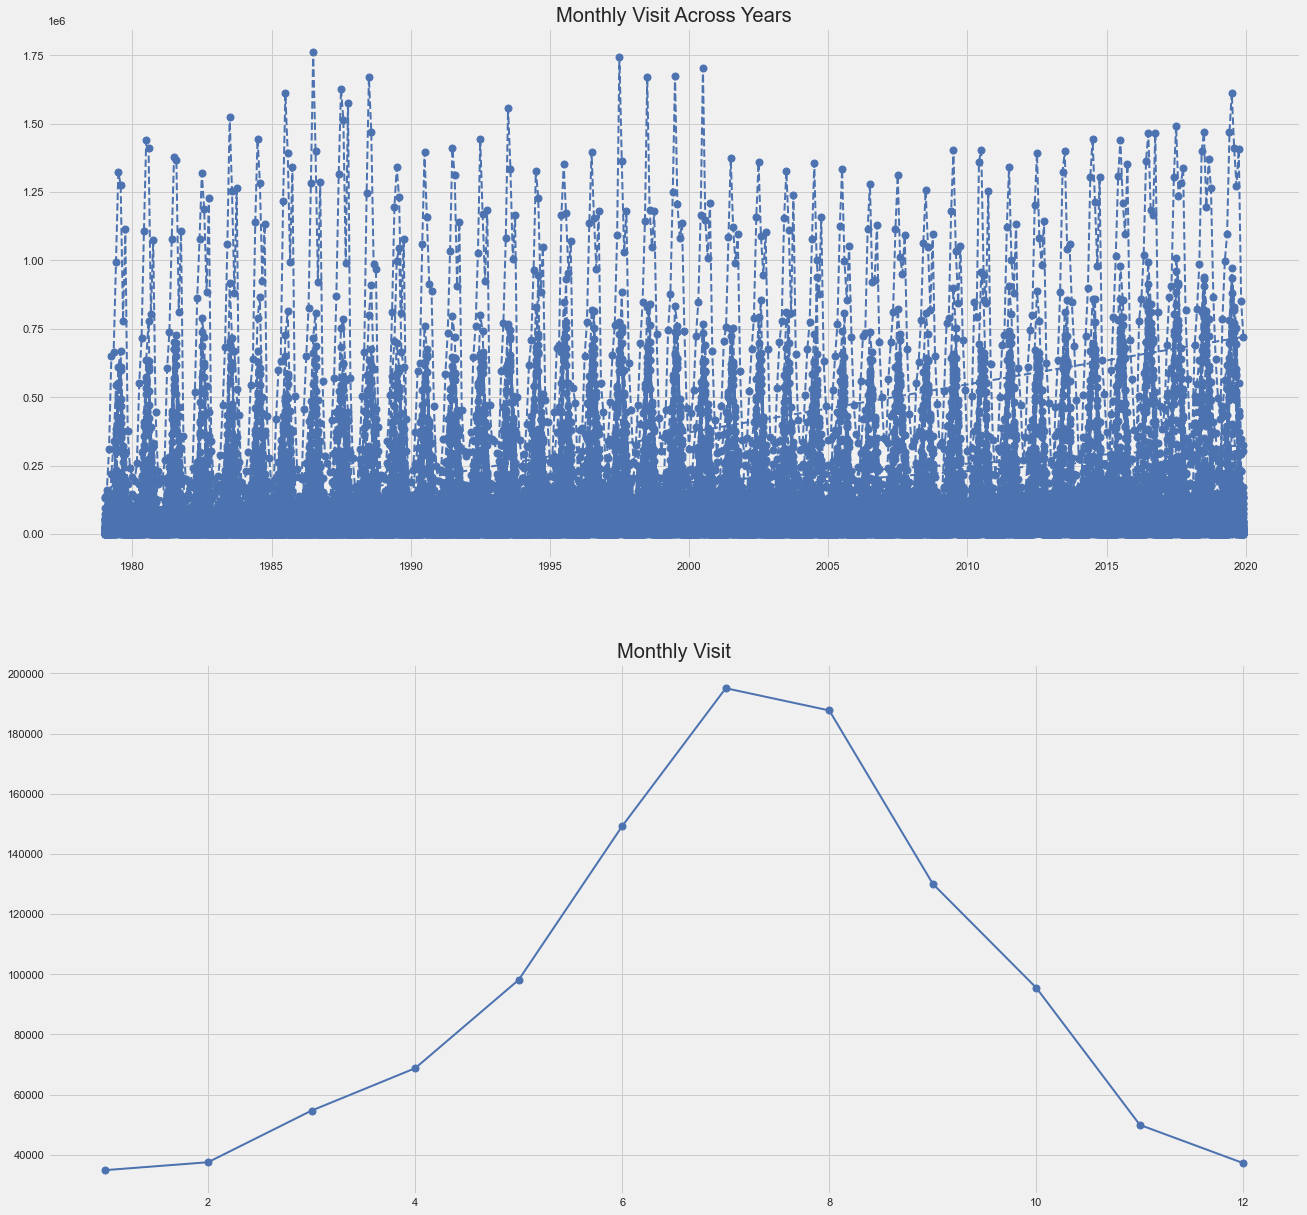

In [279]:
fig, (ax1, ax2) = plt.subplots(2, figsize= (20,20))
ax1.plot(df.Visit, marker= 'o', linestyle= '--', linewidth= 2, markersize= 7, color= 'b')
ax1.set_title('Monthly Visit Across Years')

ax2.plot(Month_mean.Visit_mean, marker= 'o', linestyle= '-', linewidth= 2, markersize= 7, color= 'b')
ax2.set_title('Monthly Visit')

In [280]:
Year_mean.drop(["Latitude", "Longitude"], axis = 1, inplace = True)
# Year_mean

Text(0.5, 1.0, 'Yearly Visit')

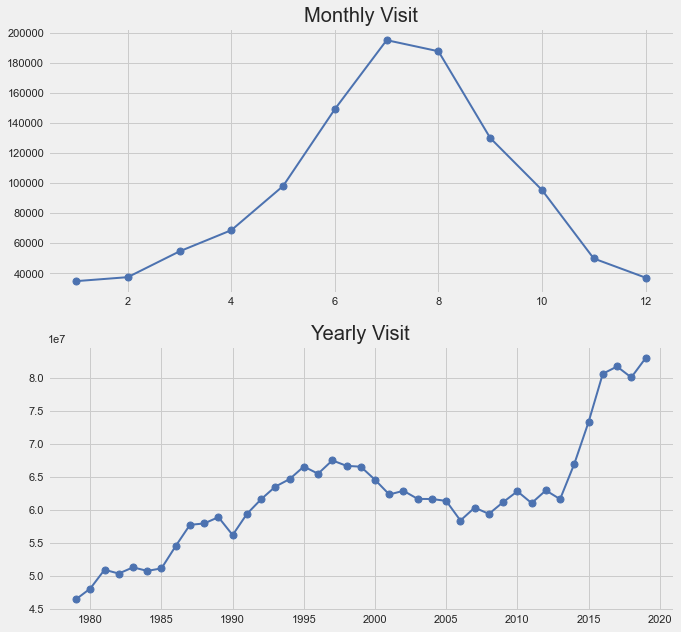

In [281]:
fig, (ax1, ax2) = plt.subplots(2, figsize= (10,10))
ax1.plot(Month_mean.Visit_mean, marker= 'o', linestyle= '-', linewidth= 2, markersize= 7, color= 'b')
ax1.set_title('Monthly Visit')

ax2.plot(Year_mean.Visit_mean, marker= 'o', linestyle= '-', linewidth= 2, markersize= 7, color='b')
ax2.set_title('Yearly Visit')

In [282]:
df.head()

,Name,Code,Region,State,Visit,Latitude,Longitude
Datetime,,,,,,,
1979-01-01,Acadia NP,ACAD,Northeast,ME,6011,44,-68
1979-02-01,Acadia NP,ACAD,Northeast,ME,5243,44,-68
1979-03-01,Acadia NP,ACAD,Northeast,ME,11165,44,-68
1979-04-01,Acadia NP,ACAD,Northeast,ME,219351,44,-68
1979-05-01,Acadia NP,ACAD,Northeast,ME,339416,44,-68


## Top 10 national parks

In [283]:
mask = (df1['Year'] == 2019) | (df1['Year'] == 2018) | (df1['Year'] == 2017)
df_top10 = df1[mask][["Name", "Year", "Visit"]].groupby(["Name", "Year"]).sum().sort_values(by = "Visit", ascending = False).reset_index().head(28)
# df_top10

Text(0.5, 1.0, 'Top 10 Popular National Parks in 2019')

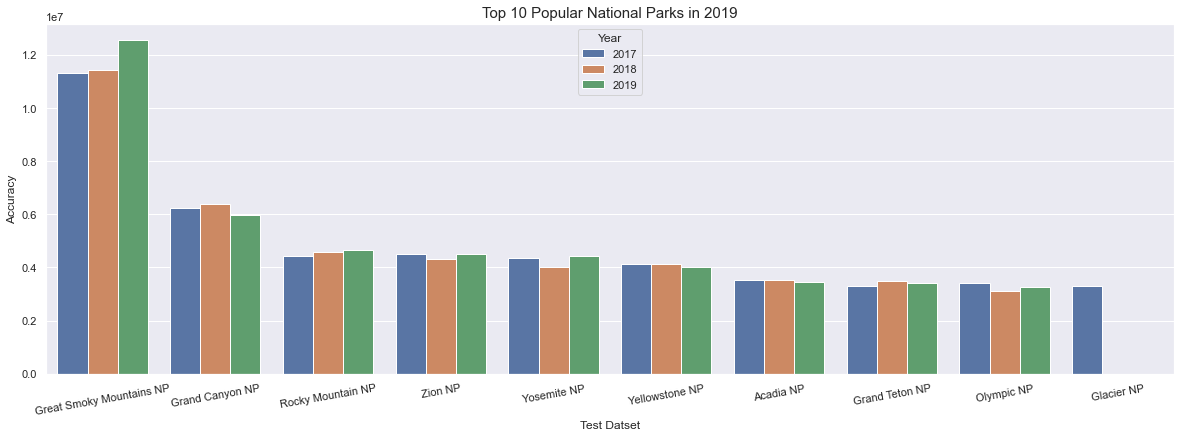

In [284]:
sns.set(rc= {"figure.figsize":(18, 6)})

ax = sns.barplot("Name", "Visit", data = df_top10, hue = "Year")
# set rotation
plt.xticks(rotation= 10)

plt.xlabel("Test Datset")
plt.ylabel("Accuracy")
# plt.ylim(0.7, 1)

plt.title("Top 10 Popular National Parks in 2019", fontsize= '15')

# for i in ax.containers:
#     labels = [f'{(v.get_height()):000,.0f}' for v in i]
#     ax.bar_label(i, labels= labels, label_type= 'edge')

# Forecast

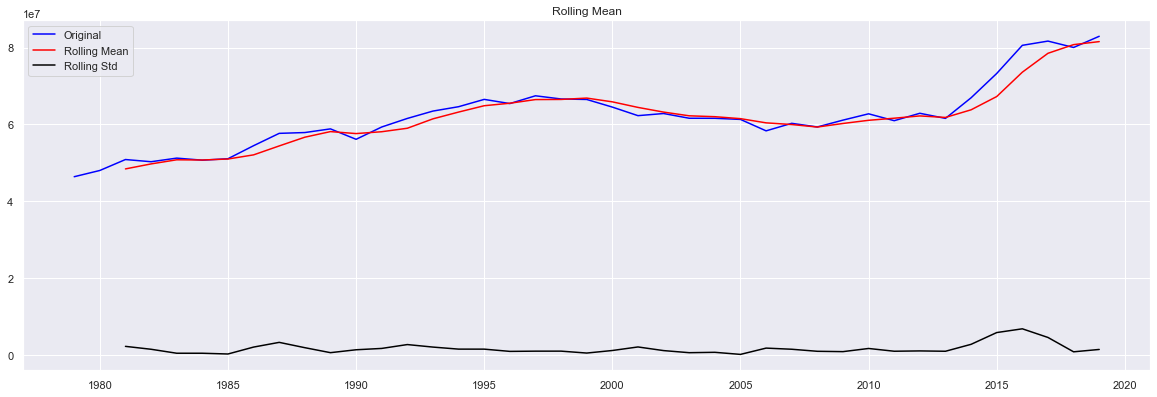

Results of Dickey-Fuller Test:
Test Statistic                 -0.339731
p-value                         0.919686
#Lags Used                      5.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


In [285]:
def stationarity(var):
    
    #Determing rolling statistics
    rolmean = var.rolling(3).mean()
    rolstd = var.rolling(3).std()

    #Plot rolling statistics:
    orig = plt.plot(var, color= 'blue', label= 'Original')
    mean = plt.plot(rolmean, color='red', label= 'Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block= False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(var, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index= ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
stationarity(Year_mean.Visit_mean)    

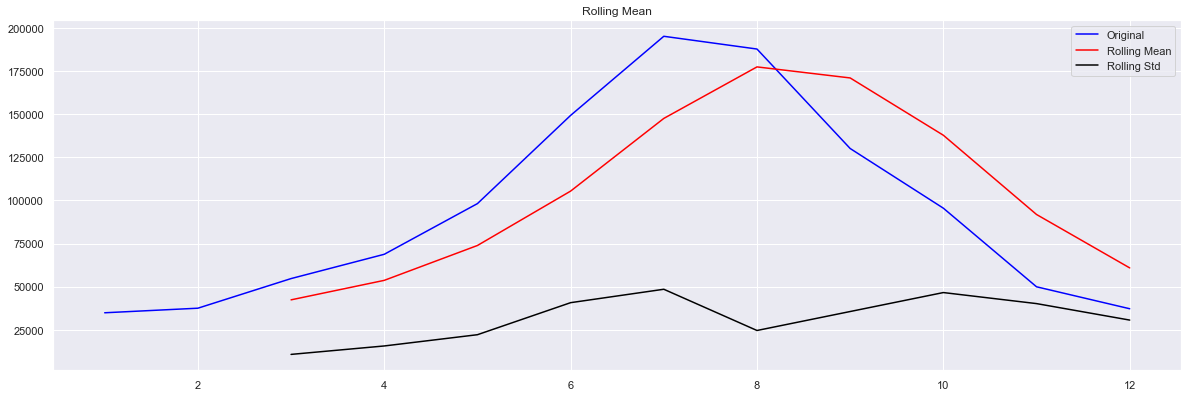

Results of Dickey-Fuller Test:
Test Statistic                -2.491336
p-value                        0.117597
#Lags Used                     4.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64


In [286]:
stationarity(Month_mean.Visit_mean)  

In [287]:
Year_mean

,Visit_mean
Year,
1979,46405206
1980,48028619
1981,50875409
1982,50304186
1983,51243179
1984,50707494
1985,51083752
1986,54474783
1987,57686801


## 1. Using Moving Average
In this case, we take  average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 3 and 5 year

Text(0, 0.5, 'Visitations')

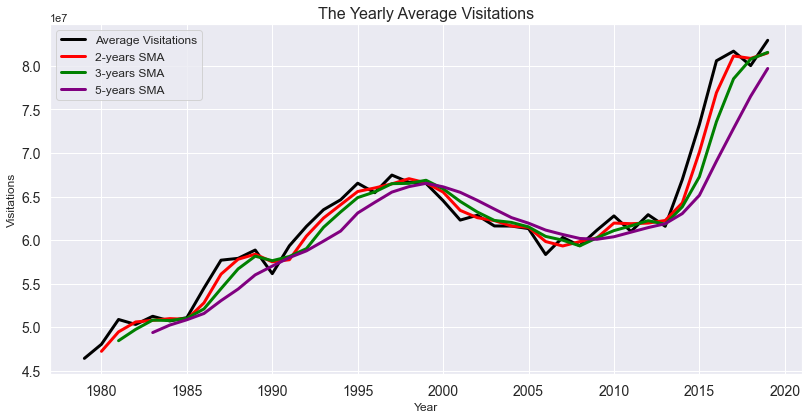

In [202]:
Year_mean["SMA_2"] = Year_mean.Visit_mean.rolling(2).mean()
Year_mean["SMA_3"] = Year_mean.Visit_mean.rolling(3).mean()
Year_mean["SMA_5"] = Year_mean.Visit_mean.rolling(5).mean()

# Line plot
# Grean = Avg Air Temp, RED = 10 yrs, ORANG colors for the line plot
colors = ['black', 'red', 'green', "purple"]
# Line plot 
Year_mean.plot(color= colors, linewidth= 3, figsize= (12, 6))
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.legend(labels = ['Average Visitations', '2-years SMA', '3-years SMA', '5-years SMA'], fontsize= 12)
plt.title('The Yearly Average Visitations', fontsize= 16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Visitations', fontsize=12)

## Cumulative Moving Average (CMA)

In [204]:
Year_mean.head()

,Visit_mean,SMA_2,SMA_3,SMA_5
Year,,,,
1979,46405206,NaN,NaN,NaN
1980,48028619,47216912.5,NaN,NaN
1981,50875409,49452014.0,4.843641e+07,NaN
1982,50304186,50589797.5,4.973607e+07,NaN
1983,51243179,50773682.5,5.080759e+07,49371319.8


In [205]:
Year_mean['CMA'] = Year_mean.Visit_mean.expanding().mean()

Text(0, 0.5, 'Visitations')

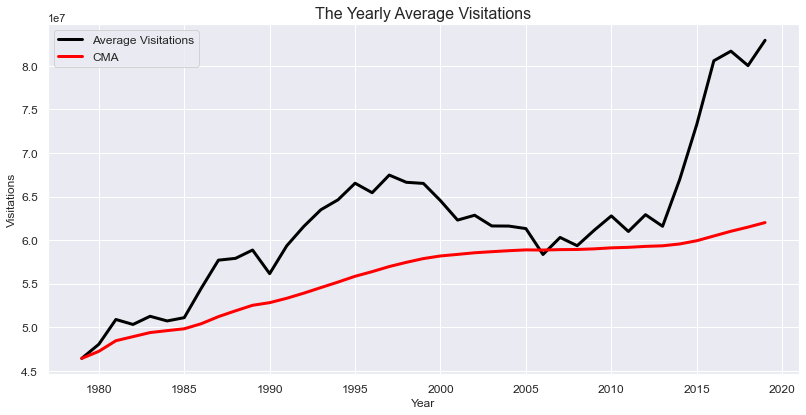

In [217]:
colors = ['black', 'red']
# line plot
Year_mean[['Visit_mean', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.legend(labels = ['Average Visitations', 'CMA'], fontsize= 12)
plt.title('The Yearly Average Visitations', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Visitations', fontsize=12)

## Exponential Moving Average (EMA)

In [230]:
# Let's smoothing factor - 0.1
Year_mean['EMA_0.3'] = Year_mean.Visit_mean.ewm(alpha= 0.3, adjust= False).mean()
# Let's smoothing factor  - 0.3
Year_mean['EMA_0.7'] = Year_mean.Visit_mean.ewm(alpha= 0.7, adjust= False).mean()

Text(0, 0.5, 'Visitations')

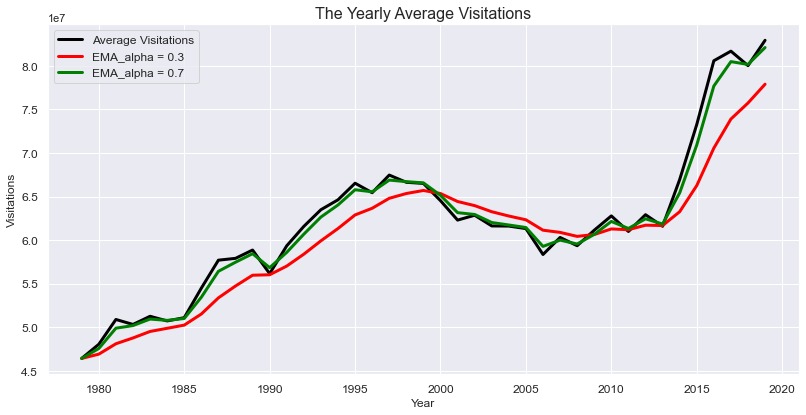

In [231]:
colors = ["black", 'red', 'green']
# line plot
Year_mean[['Visit_mean', 'EMA_0.3', 'EMA_0.7']].plot(color=colors, linewidth=3, figsize=(12,6))
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.legend(labels = ['Average Visitations', 'EMA_alpha = 0.3', 'EMA_alpha = 0.7'], fontsize= 12)
plt.title('The Yearly Average Visitations', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Visitations', fontsize=12)

In [244]:
Year= Year_mean.reset_index()[["Year", "Visit_mean"]]
# Year

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


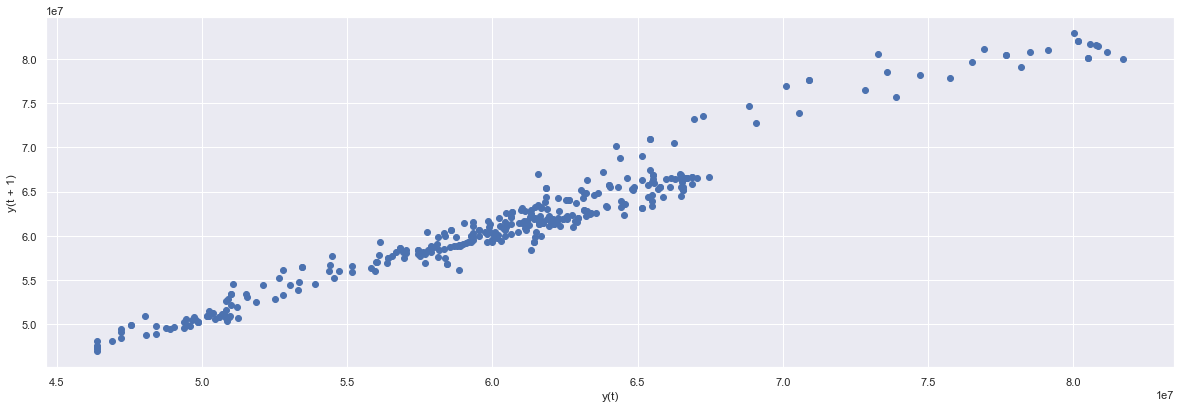

In [264]:
from matplotlib import pyplot
from pandas.plotting import lag_plot
lag_plot(Year_mean)
pyplot.show()

## Look upward linearly trend

In [307]:
Year_mean.drop(["Latitude", "Longitude"], axis = 1 , inplace = True)
Year_mean.head()
# Year_mean = Year_mean.reset_index()
# Year_mean

,Visit_mean
Year,
1979,46405206
1980,48028619
1981,50875409
1982,50304186
1983,51243179


<AxesSubplot:xlabel='Year'>

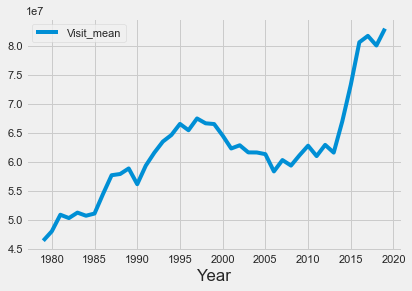

In [308]:
Year_mean.plot()

In [314]:
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(Year_mean, order=(0,1,1))
result = model.fit()

# model = ARIMA(Year_mean, order=(0, 1, 1)) 
# results_ARIMA = model.fit()

In [316]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Visit_mean   No. Observations:                   41
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -645.034
Date:                Sun, 20 Nov 2022   AIC                           1294.068
Time:                        13:38:45   BIC                           1297.446
Sample:                             0   HQIC                          1295.289
                                 - 41                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0547      0.085      0.644      0.519      -0.112       0.221
sigma2      6.057e+12   3.76e-15   1.61e+27      0.000    6.06e+12    6.06e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                 2.87
Prob(Q):                              0.39   Prob(JB):                         0.24
Heteroskedasticity (H):               2.66   Skew:                             0.65
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [322]:
result.forecast(2)

41    8.310938e+07
42    8.310938e+07
Name: predicted_mean, dtype: float64

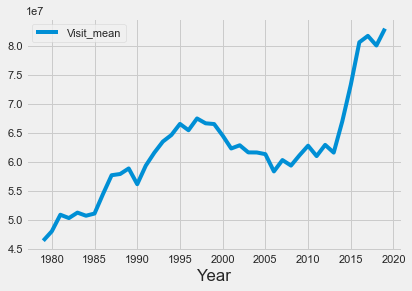

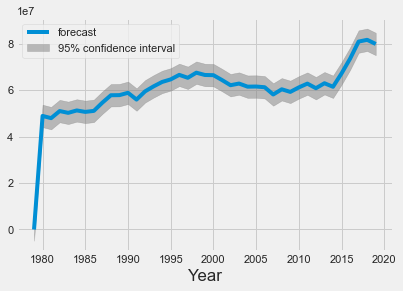

In [326]:
from statsmodels.graphics.tsaplots import plot_predict
Year_mean.plot()
plot_predict(result)
plt.show()